Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Learning Gremlin - Basic Read Queries

This notebook is the first in a series of notebooks that walk through how to write queries using Gremlin.  In this notebook, we will examine the basics of Gremlin read queries and how these queries fit into the "Find", "Filter", "Format" paradigm.  Let's begin by loading some sample data into our Neptune cluster.  




## Getting Started

For these notebooks, we will be leveraging a dataset from the book [Graph Databases in Action](https://www.manning.com/books/graph-databases-in-action?a_aid=bechberger) from Manning Publications.  


**Note** These notebooks do not cover data modeling or building a data loading pipeline.  If you would like a more detailed description about how this dataset is constructed and the design of the data model came from then please read the book.

To get started, the first step is to load data into the cluster.  Assuming the cluster is empty, this can be accomplished by running the cell below which will load our Dining By Friends data.

### Before you begin

Throughout all the **Learning Gremlin on Neptune** notebooks, you will notice that each code block starts with either a `%` or `%%` command. These are called *workbench magic* commands, and are essentially shortcuts to specific Neptune APIs. For example:

* `%%gremlin` - issues a Gremlin query to the Neptune endpoint usng WebSockets
* `%seed` - provides a convenient way to add sample data to your Neptune endpoint
* `%load` - generates a form that you can use to submit a bulk load request to Neptune

For more information on workbench magics, and to see all the supported commands, refer to the [Using Neptune workbench magics in your notebooks](https://docs.aws.amazon.com/neptune/latest/userguide/notebooks-magics.html) user guide.

### Loading Data

Run the following command to load the sample data set that we'll be using. We'll only need to run this once, and ensure your database is empty before doing so.

In [ ]:
%seed --model property_graph --language gremlin --dataset dining_by_friends --run

### Setting up the visualizations

Run the next two cells to configure various display options for our notebook, which we will use later on to display our results in a pleasing visual way.  

In [ ]:
%%graph_notebook_vis_options
{
  "groups": {    
    "person": {
      "color": "#9ac7bf"
    },
    "review": {
      "color": "#f8cecc"
    },
    "city": {
      "color": "#d5e8d4"
    },
    "state": {
      "color": "#dae8fc"
    },
    "review_rating": {
      "color": "#e1d5e7"
    },
    "restaurant": {
      "color": "#ffe6cc"
    },
    "cusine": {
      "color": "#fff2cc"
    }
  }
}

The following cell creates the `node_labels` object which we use to tell the Notebook which property we want to display when creating graphical visualisations.

In [ ]:
node_labels = '{"person":"first_name","city":"name","state":"name","restaurant":"name","cuisine":"name"}'

We'll be using the `node_labels` variable to provide a nicer visualisation when running the queries in this notebook. To use it, we need to pass it along with the query itself, as follows:

`%%gremlin -d node_labels`

The `-d` instructs the notebook as to which properties should be displayed for each specified node label.

### Looking at our graph data

Now that we have loaded our data, let's take a moment to look at what our data model looks like:


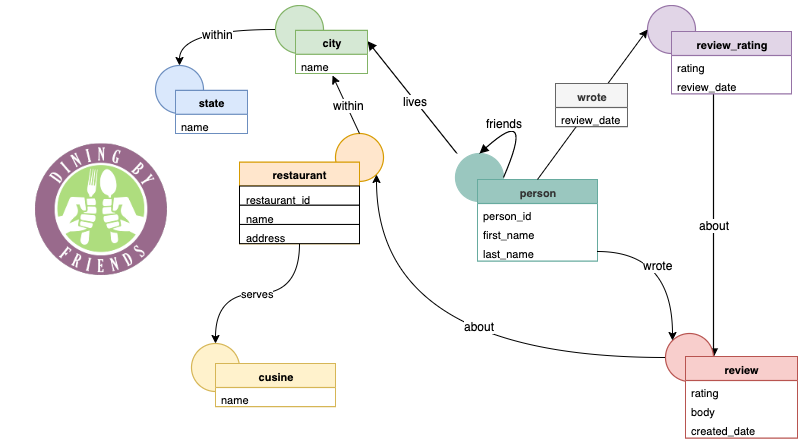

<table>
    <tr><th colspan=3 style="text-align: center">Element (Node/Edge) Counts</th>
    </tr>
<tr><td style="width:40%">
    
|Node Label|Count|
|:--|:--|
|review|109|
|restaurant|40|
|cuisine|24|
|person|8|
|state|2|
|city|2|
    
</td>
    <td></td>
    <td style="width:40%">

|Edge Label|Count|
|:--|:--|
|wrote|218|
|about|218|
|within|84|
|serves|80|
|friends|20|
|lives|16|

</td></tr> </table>

This dataset represents a fictitious, but realistic, restaurant recommendation application that contains:

* Users, represented by `person` nodes
* Users connected to Users via `friends` edges
* Restaurants and their associated information (`city`, `state`, `cuisine`)
* Reviews include the body and ratings
* Ratings of reviews (helpful/not helpful)

This application contains three main aspects to the data it collects.  First, it contains a social network consisting of `person` nodes connected to other `person` nodes via a `friends` edge.  Second, it contains a restaurant review aspect consisting of `restaurant` nodes, information about those restaurants (`city`/`state`/`cuisine`), and `review` nodes for that restaurant.  The third, and final aspect, consists of a personalization component where a `person` can rate a `review`, which allows for better recommendations based on a person's preferences.

Throughout this set of notebooks, we will leverage the different aspects of this data to highlight different fundamental types of common property graph queries, namely neighborhood traversals, hierarchies, paths, and collaborative filtering.

Now let's get started.


## Finding your Data

When working with Gremlin, the most common usage of the language is to find data.  Gremlin accomplishes this using the following constructs:

* `V()` - used to access nodes in the graph
* `E()` - used to access edges in the graph
* `has()` - used to filter for objects with a property of a specific value
* `hasLabel()` - used to filter for objects with a specific label or labels.

To access nodes and edges, you must first get access to the graph itself. In Neptune, this is prebound to a variable called `g`, which is used as the first step in any Gremlin query.

Gremlin supports a number of steps that help us traverse the graph. Some of these steps are listed below:

#### Gremlin Steps

|   Gremlin Steps|Description|
|:--|:--|
|`both()`|Follow edges in either direction|
|`outE()`|Include the outgoing edges in the query (to check a label or property for example)|
|`inE()`|Include the incoming edges in the query (to check a label or property for example)|
|`bothE()` |Include edges in either direction in the query|
|`outV()`|The node on the other end of an outgoing edge|
|`inV()`|The node on the other end of an incoming edge|
|`otherV()`|The node on the other end of either an outgoing or incoming edge|


Now that we have a basic understanding of Gremlin's traversal steps, let's take a look at how this is applied to answer some common graph query patterns.

### Finding Nodes

The simplest traversal you can do in Gremlin is to search for nodes. In Gremlin traversals, nodes are represented by `V()`. In our example, *review*, *restaurant*, *cuisine*, *person*, *state* and *city* as represented as nodes.

Execute the query below to search for all nodes and return them, but limit the number returned to 10.

In [ ]:
%%gremlin
g.V()        //find me all reviews, restaurants, cuisines, persons, states and cities
.limit(10)   //return only 10 results
.elementMap()

### Finding Edges

The example above works, however it does not leverage the connections within the data, represented by edges in our graph, that make graph databases powerful.  

To perform a search across multiple nodes and edges, we need to use our traversal to specify how the nodes and edges are related using the following syntax:


|   Gremlin Step|Description|
|:--|:--|
|`outE()`|Include the outgoing edges in the query (to check a label or property for example)|
|`inE()`|Include the incoming edges in the query (to check a label or property for example)|
|`bothE()` |Include edges in either direction in the query|

Execute the query below to search for node-edge->node patterns described by the `V().inE().outV()` steps, and return 10 results.

In [ ]:
%%gremlin
g.V()        //find me all nodes
.inE()       //traverse to the incoming edge
.outV()      //find the outgoing node
.limit(10)   //return only 10 results
.elementMap()

In the example above we specified using incoming edges, using the `inE()` step, but we could have also chosen to look for patterns using only outgoing edges, `outE()`, or ignoring edge direction, `bothE()`.  

To build more complex patterns, we can use these basic constructs to link together multiple levels of connections to find more complex patterns.  In the example below, we have extended our previous query to return 10 nodes that have both incoming and outgoing edges, by specifying a `node-edge->node<-edge-node` pattern.

In [ ]:
%%gremlin
g.V()        //find me all nodes
.outE()     //traverse the outgoing edges
.inV()      //find the node at the end of the edge
.inE()      //traverse the incoming edge
.outV()     //find the outgoing edge
.dedup()     //remove any duplicates
.limit(10)  //return only 10 results
.elementMap()

We can also do the same using the combination of `bothE()` and `otherV()`, instead of explicitly stating whether to travese outgoing or incoming edges.

In [ ]:
%%gremlin
g.V()        //find me all nodes
.bothE()     //traverse both outgoing and incoming edges
.otherV()    //find the node at the end of the edge
.dedup()     //remove any duplicates
.limit(10)  //return only 10 results
.elementMap()

In the example above, we have returned matches based on a series of connected nodes and edges.  When working with graphs, a series of connected nodes and edges may also be referred to as a 'path'.  Often when we are looking for patterns within our graph we would like to return not just a node or edge within the pattern but the path containing how these items are connected.


### Finding Paths

To find paths within our graph we can use the constructs we have already learned to specify that we want the path returned. In our previous queries, we started at every node and traversed to the adjacent node using the incoming edge using `inE()`, the outgoing edge using `outE()`, or disregarded the edge direction using `bothE()`. However, we only returned the adjacent node, and not the path.

To return the path, we use the `path()` step. This will return traversal information for all paths that have been crossed.

In [ ]:
%%gremlin
g.V()        //find me all nodes
.bothE()     //traverse both outgoing and incoming edges
.otherV()    //find the node at the end of the edge
.dedup()     //remove any duplicates
.path()      // <-- now return the path
.by(elementMap())
.limit(10)  //return only 10 results

## Filtering your Data

So far, we have learned how to find specific patterns within our graph based on how the nodes and edges connect.  However, most of the time you will want to use attributes of the nodes and edges to filter the results to return a more specific subset of data.  

We accomplish this using the `has()` or `where()` steps. Using the `has()` step filters the traversal based on the existence of a property with a specific value. We can use the `where()` step to filter the traversal based on the existence of a matching traversal. 

This is an **important** differentiation between the two filtering steps. For example, if you wanted to filter based on the existence of a property, or if a property value matched an arbitrary value, you would use `has()`:

`g.V().has('name','Dave')`

Alternatively, if you wanted to filter based on a traversal, you would use `where()` instead. For example, if you wanted all nodes with more than 100 outgoing connections, you could use a query such as that below:

`g.V().where(out().count().is(gt(100)))`

Within both the `has()` and `where()` steps, there are a variety of predicates available to perform logical operations and comparisons of the data. Below is a listing of the some of the predicates supported by Gremlin.

### Predicate Functions ###

Predicates are functions used to compare values based on equality, ranges or certain patterns. Below is a list of some of the predicates supported by Gremlin. These are implemented in either the [TextP](https://tinkerpop.apache.org/javadocs/current/core/org/apache/tinkerpop/gremlin/process/traversal/TextP.html) or [P](https://tinkerpop.apache.org/javadocs/current/core/org/apache/tinkerpop/gremlin/process/traversal/P.html) traversal classes  

|Type|Predicate|
| ----------- | ----------- |
|General|`within()`, `without()`, `between()`|
|Math|`eq()`, `neq()`, `gt()`, `lt()`, `gte()`, `lte()`|
|String|`startingWith()`, `endingWith()`, `notStartingWith()`, `notEndingWith()`, `containing()`, `notContaining()`|
|Boolean|`and()`, `or()`, `not()`|
|Regex|`regex()`, `notRegex()`|

### Filtering Steps ###

In addition to the predicate functions listed above, Gremlin also supports steps which provide filtering functionality. Below is a list of some of the supported steps:

|Gremlin Step|Description|Example|
| ----------- | ----------- | ----------- |
|`is()`|Filter scalar values|`g.V().values('age).is(32)`|

### Reducing Barrier Steps ###

Finally, Gremlin supports steps that are defined as `reducing barrier steps`. So what is a Reducing Barrier Step? A full definition can be read in the [official Tinkerpop Apache](https://tinkerpop.apache.org/docs/3.7.0/reference/#a-note-on-barrier-steps), but a shorter explanation is provided below as follows:

_"Gremlin is a lazy stream processing language. This means it will not evaluate data within a traversal until it reaches a step (called a `reducing barrier step`) that requires all the previous traverses to be processed, and a single 'reduced value' traverser to be emitted to the next step."_

Some examples of `reducing barrier steps` are as follows:

|Type|Step
| ----------- | ----------- |
|List|`fold()`|
|Math|`count()`, `sum()`, `max()`, `min()`|
|Aggregation|`group()`,`groupCount()`|


In the next sections, we will look at some common ways to apply filters using predicates and filtering steps, as well as using barrier steps to modify our return values.

### Filtering Nodes by Label

One of the most common items you will want to filter on will be the label(s) associated with a node. This can be accomplished by using the `hasLabel()` step.

In [ ]:
%%gremlin
g.V()
.hasLabel('person') // <-- find all person nodes
.limit(10)
.elementMap()

#### Filtering by multiple labels using `hasLabel()`

In Property Graph, nodes can have multiple labels associated with them, so you may need to filter across more than one label. You can do this using the example below:

In [ ]:
%%gremlin
g.V()
.hasLabel('person','restaurant') // <-- filter on the node label, e.g. find all person and restaurant nodes
.limit(10)
.elementMap()

### Filtering Edge by Label
Another common item you to filter on is the type or label associated with an edge. As with nodes, you can use the `hasLabel()` step associated with an edge.

In [ ]:
%%gremlin -d $node_labels
g.V()
.hasLabel('person') // <-- find all person nodes
.inE()
    .hasLabel('friends')  // <-- filter on the edge label
.outV()
.path()
.by(elementMap())
.limit(10)

What about if we only wanted to include people who have 2 or more connected friends? We can use some of the predicates we mentioned earlier:

In [ ]:
%%gremlin -d $node_labels
g.V()
.hasLabel('person')
.where(out().hasLabel('person').count().is(gte(2))) // <-- filter only people who have at 2 or more friend connections
.outE()
    .hasLabel('friends')
.inV()
.path()
.by(elementMap())
.limit(10)

What if we wanted to get a list of all the restaurants in order to find out which cuisine's they serve? After all, all this learning has made me hungry!

In [ ]:
%%gremlin -d $node_labels
g.V()
.hasLabel('restaurant')     // <-- get all the restaurant nodes
.out()
    .hasLabel('cuisine')    // <-- traverse outwards to the cuisine nodes
.path()                     // <-- get the path
.by(values('name'))         // <-- return the 'name' property for all nodes in the traversals

You'll have noticed we used `by()` and `values()` in the above step. This was to be able to format the results to show the `name` property of each of the nodes in the traversal. We'll be explaining how these work in more detail in the **Formatting Results** section below.

### Finding by Property

The next common use case for filtering is to be able to filter on attribute values. 

This can be accomplished by using the `has()` step as described above, which applies to both nodes and edges.


In [ ]:
%%gremlin
g.V()                       // <-- start with all nodes
.has('first_name','Dave')   // <-- filter nodes which have a 'first_name' property value of 'Dave'
.limit(10)
.elementMap()

Because there are no properties associated to any of our edges, running the following query won't return any records. However, you can use it to see how the same concept of filtering nodes based on properties can be applied to edge.s

In [ ]:
%%gremlin
g.V()                   // <-- start with all nodes
.outE()                 // <-- traverse the outbound edge, landing on that edge
.has('weight', 1)       // <-- filter edges which have a 'weight' property value of '1'
.elementMap()

## Formatting Results

Having gone through the basics of finding and filtering data with Gremlin, let's take a look at the last step, formatting our results.  Almost all Gremlin queries will return a value. How this is formatted depends on the traversal and formatting steps.


### Returning all values

By default, Gremlin will only return the object id in the result set, in the format of `v[<id>]` for nodes and `e[<id>]` for edges. Run the following code to see an example:

In [ ]:
%%gremlin
g.V()
.hasLabel('person')
.limit(10)

This is great, but isn't particularly useful unless we're pairing it up with data stored elsewhere. Instead, we'd like to retrieve properties about each returned node, and we have three options to be able to do this:

* `valueMap()` - returns a map of all the non-internal property values. Use `valueMap().with(WithOptions.tokens)` to include internal properties such as id and label.
* `values()` - returns each non-internal property as an individual row.
* `elementMap()` - returns a map of ALL property values

`valueMap()`, `values()` and `elementMap()` also accept a property name, or list of properties to return, as shown below:

In [ ]:
%%gremlin
g.V()
.hasLabel('person')
.values('first_name')

In [ ]:
%%gremlin
g.V()
.hasLabel('person')
.elementMap('first_name')

**Note**, If you only need to return specific properties from a query, it's recommended that you provide the names of the required properties, so it doesn't return more data than you need.

It's important to understand the difference between `valueMap()` and `elementMap()`. Whilst both return properties as a map, they do so in fundamentally different ways.

With `valueMap()` all non-internal properties are returned (unless `.with(WithOptions.tokens)` is specified). In addition, all property values are represented as lists, even if there is only a single property value.

With `elementMap()` all properties are returned, however unlike `valueMap()` they are not returned as list members. Where you have list or set property containing multiple values, **only the first member is returned**. If you need to return these types of properties, you should use `valueMap()` instead. 

In addition, when using `elementMap()` with edges, additional information regarding the attached vertices is also returned. The following query demonstrates this.

In [ ]:
%%gremlin

g.V().limit(1).outE().limit(1).elementMap()

### Returning property values

Most often, you want to be specific about the data elements (node/edges), attributes, or a combination of both, that a query returns.  This provides for efficient processing, both at the database and client level, and efficient data transmission, since we are only retrieving, processing, and sending what is needed.  

As we've already seen, Gremlin will only return the results at the end of the traversal, so how do we obtain details of objects that are specified higher up in the traversal? To accomplish this, we can use the `select()` and `project()` steps.

#### Selecting and Aliasing

We can use `select()` to refer to objects that have been aliased previously in the traversal using the `as()` step. Below is an example of how this is achieved:

In [ ]:
%%gremlin
g.V()
.has('first_name','Dave').as('dave')
.out()
.hasLabel('person').as('friend')
.select('dave','friend')
.by('first_name')
.by('first_name')

The above query is quite a jump from our previous examples, so let's breakdown the steps:

* `g.V()` - start by looking at all the nodes
* `.has('first_name','Dave').as('dave')` - find all nodes with a `first_name` property value of `Dave`. Store these nodes under the alias of `dave`.
* `.out().hasLabel('person').as('friend')` - traverse the outgoing edge to an adjacent `person` node. Store these nodes under the alias of `friend`.
* `.select('dave','friend')` - refer to the previously aliased traversals using the `select()` step.
* `.by('first_name')` - this determines how to format the output of each of the aliased objects. In this case, we're only outputting the `first_name` property for all nodes in the `dave` and `friend` variables.

**Note** When using `by()` after a `select()` you must specify the same number of `by()` statements as there are variables in the `select()`. Failing to doing so, will cause Gremlin to re-use whichever by() statements have been specified, starting with the first one. Now, this may not always be a problem, as we can see in the next example:

In [ ]:
%%gremlin
g.V()
.has('first_name','Dave').as('Me')
.out()
.hasLabel('person').as('MyFriends')
.select('Me','MyFriends')
.by('first_name')

The above query is the same as before, however because we only want to return the `first_name` property from nodes in both the `dave` and `friend` aliases, we only need to specify one `by()` modulator.

#### Projection

Unlike `select()` that aliases previous traversals, the `project()` step takes data from the incoming traversal and moves forward with it. The following example shows how to use `project()` to return the same results as `select()`:

In [ ]:
%%gremlin
g.V()
.has('first_name','Dave').as("Me")
.out()
    .hasLabel('person').values('first_name').as("MyFriend")
.project('Me','MyFriend')
    .by(select("Me").values('first_name'))
    .by(select("MyFriend"))

Notice in the above query how we've combined `project()` and `select()` to provide us with the same results. This is because to we've needed to alias specific portions of the incoming traversal, e.g. the node representing *Dave*, and the nodes representing Dave's *friends*.

If we were to run the following query, you'll notice something very odd happen with the results.

In [ ]:
%%gremlin
g.V()
.has('first_name','Dave')
.project('Me','MyFriends')
.by(values('first_name'))
.by(out().hasLabel('person').values('first_name'))

The query looks like it should return the `first_name` value of the node representing *Dave*, and then return the `first_name` property of all the outbound `person` nodes associated with Dave. So why didn't it?

It's because the first `.has('first_name','Dave')` step created a single traverser. This was the input to the `project()` step. From here, the `.by(out().hasLabel('person').values('first_name'))` step is essentially executing a **sub-query** at this point, which is why it only returns a single row. If you've ever written sub-queries in SQL, you'll know that they're only allowed to return one row, and this query follows the same pattern.

So how do we solve this? We can use the `fold()` step to bundle up all the `first_name` values into a single value, and return this instead.

### Returning unique values

To return unique values in the results, we can use the `dedup()` step. This can be used in two ways:

* to remove duplicates from the incoming traversal
* to only return unique values based on a `by()` modulation

Both applications are shown below:

In [ ]:
%%gremlin
g.V()
.hasLabel('person')
.both().hasLabel('person')
.dedup()
.values('first_name')
.limit(10)

In [ ]:
%%gremlin
g.V()
.hasLabel('person')
.dedup()
.by('first_name')
.values('first_name')

### Returning custom values

In addition to returning simple key-value pairs, we can construct more complex responses. This is a common requirement, especially when returning aggregations or when returning attributes from different variables in the matched patterns.

These new projections are created by using the `by()` step modulator (which is discussed more in the Loops-Repeats notebook). As we're previous seen, for each traversal step, we write a `by()` step to apply to it. The example below shows how we can return a custom string with the statement "*person* is friends with *person*".

In [ ]:
%%gremlin
g.V()
.out().hasLabel('person')
.out().hasLabel('person')
.path()
.by('first_name')
.by(constant(' is friends with '))
.by('first_name')

## Exercises

Now that we have gone through the basics of writing Gremlin read queries, it's time to put it into practice! Below are several exercises you can complete to verify your understanding of the material covered in this notebook.  As practice for what you have learned, please write the Gremlin queries specified below.

Using the social network portion (`person` and `friends`) of our Dining By Friends graph, let's answer the following questions:


### Exercise 1: Find the first name of Dave's friends

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer is four results: "Josh", "Hank", "Kelly", "Jim"

In [ ]:
%%gremlin


### Exercise 2: Find the first name of the friends of Dave's friends

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the friends `first_name`

The correct answer contains three results: "Hank", "Denise", "Paras"

In [ ]:
%%gremlin



### Exercise 3: Find out how the friends of Dave's friends are connected

Using the data model above, write a query that will:

* Find a `person` node(s) with a `first_name` of "Dave"
* Find the friends of Dave (i.e. traverse the `friends` edge)
* Find the friends of that person (i.e. traverse the `friends` edge)
* Return the path

The correct answer contains three results:

- `Dave` -> `Josh` -> `Hank`
- `Dave` -> `Kelly` -> `Denise`
- `Dave` -> `Jim` -> `Paras`

In [ ]:
%%gremlin


### Exercise 4: Which friends should we recommend for Dave?

A common use case for graphs in social networks is to recommend new connections.  There is a significant amount of research in this area (example [here](https://www.science.org/doi/10.1126/sciadv.aax7310#:~:text=The%20triadic%20closure%20mechanism%20uses,features%20of%20empirical%20social%20networks)) but mainly there are two prevailing mechanisms at work in social networks that we can leverage to help provide efficient recommendations to a user.  The first of these mechanisms is called homophily, which is the tendency of similar people to be connected.  Homophily is a driving factor in many social networks, with an important outcome being that people connected to you, or connected to people that are connected to you, tend to be similar to you.  This leads to the second mechanism in a graph, the concept of a triadic closure.  Triadic closure is a way to create or recommend new connections based on common friends or acquaintances.  


In this exercise, we are going to leverage triadic closure to recommend friends for Dave.  To accomplish this, we will need to leverage the previously written queries but extend them to:

* Find all the friends of friends that do not have a connection to Dave

The correct answer contains three results: "Hank", "Denise", "Paras"

In [ ]:
%%gremlin


## Conclusion

In this notebook, we explored the basics of writing Gremlin queries and how they are represented in the "Find", "Filter", "Format" paradigm. First, we learned the basics of how to specify the steps used to match on data in our queries. Next, we learned several different mechanisms for how to filter the data found by our queries to return the correct results. Finally, we learned how to specify the format of the data being returned from a query to make for efficient use of database and application resources.

In the next notebook, we will take what we have learned in this notebook and extend it to show how to answer questions where the length of the patterns is variable or unknown.